[*********************100%***********************]  1 of 1 completed

Epoch 1/10



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0523
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0032
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0029
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0025
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0021
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019
Epoch 9/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0020
Epoch 10/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0019
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━

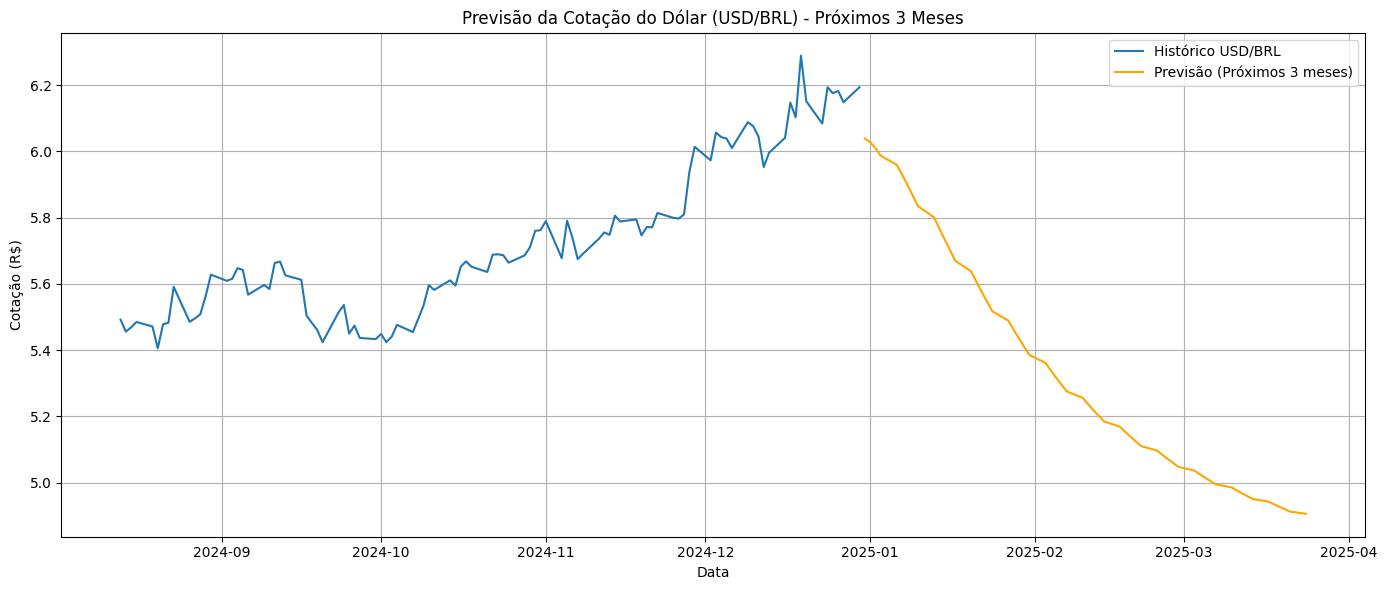

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Baixando dados do USD/BRL
df = yf.download('USDBRL=X', start='2020-01-01', end='2024-12-31')
df = df[['Close']].dropna()

# Normalizando os dados
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Criando janelas de tempo (lookback = 60)
def create_dataset(data, lookback=60):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

lookback = 60
X, y = create_dataset(scaled_data, lookback)

# Ajustando para LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Modelo LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=10, batch_size=32)

# Prevendo os próximos 3 meses (~60 dias úteis)
last_60_days = scaled_data[-60:]
predictions = []

current_input = last_60_days.copy()
for _ in range(60):  # aproximadamente 3 meses úteis
    input_reshaped = np.reshape(current_input, (1, lookback, 1))
    next_pred = model.predict(input_reshaped)
    predictions.append(next_pred[0, 0])
    current_input = np.vstack([current_input[1:], [[next_pred[0][0]]]])

# Reescalonando os valores para o original
predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Criando datas futuras
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=60, freq='B')

# Criando DataFrame de previsão
forecast_df = pd.DataFrame({'Data': future_dates, 'Previsão USD/BRL': predicted_prices.flatten()})
forecast_df.set_index('Data', inplace=True)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df[-100:], label='Histórico USD/BRL')
plt.plot(forecast_df, label='Previsão (Próximos 3 meses)', color='orange')
plt.title('Previsão da Cotação do Dólar (USD/BRL) - Próximos 3 Meses')
plt.xlabel('Data')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

